In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange

In [3]:
class Dataset(torch.utils.data.Dataset):
    """
    overload dataset
    """

    def __init__ (self, images, labels):
        self.images = images
        self.labels = labels
        self.images = self.images.float()
        self.labels = self.labels.long()

    def __len__ (self): 
        return(len(self.images))

    def __getitem__ (self, idx):
        return self.images[idx], self.labels[idx]
    
    def shuffle(self):
        idx = torch.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]
    
    def train_val_test_split(self, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15):
        # split the data
        self.shuffle()
        train_data = self[:int(train_percentage*self.__len__())]
        val_data = self[int(train_percentage*self.__len__()):int((train_percentage+val_percentage)*self.__len__())]
        test_data = self[int((train_percentage+val_percentage)*self.__len__()):]
        return Dataset(train_data[0], train_data[1]), Dataset(val_data[0], val_data[1]), Dataset(test_data[0], test_data[1])

In [4]:
# load the data
data = torch.load('data/leukemia/leukemia_dataset.pt')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [7]:
class LeukemiaClassifier(nn.Module):
    def __init__(self):
        super(LeukemiaClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # RGB images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 28 * 28  # Adjusted for 224x224 input size
        self.fc = nn.Linear(fc_input_size, 4) # Adjusted for 4 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        return x

In [9]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in trange(epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
            # Print the loss
            # if i % 10 == 0:
            #     print(f'Epoch {epoch}, Iteration {i}, Loss {loss.item()}')

        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Validation Loss {val_loss / len(val_data)}')

    return train_losses, val_losses

In [10]:
#  set the seed before the split
torch.manual_seed(42)
data_train, data_val, data_test = data.train_val_test_split()

# Create the DataLoaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=data_test.__len__(), shuffle=False)


In [12]:
# Example instantiation and training
# model = BrainClassifier()
model = LeukemiaClassifier()
tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=400, lr=0.000001)

tend = time.time()
print("Time elapsed: ", tend-tstart)

  0%|                                                                             | 0/400 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/ipasia00/deepenv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
  0%|▏                                                                    | 1/400 [00:03<24:24,  3.67s/it]

Epoch 0, Validation Loss 1.4832934439182281


  2%|█                                                                    | 6/400 [00:09<08:12,  1.25s/it]

Epoch 5, Validation Loss 1.248766291886568


  3%|█▊                                                                  | 11/400 [00:14<07:29,  1.16s/it]

Epoch 10, Validation Loss 1.0389281809329987


  4%|██▋                                                                 | 16/400 [00:20<07:24,  1.16s/it]

Epoch 15, Validation Loss 0.9240979552268982


  5%|███▌                                                                | 21/400 [00:26<07:18,  1.16s/it]

Epoch 20, Validation Loss 0.8854122310876846


  6%|████▍                                                               | 26/400 [00:32<07:08,  1.15s/it]

Epoch 25, Validation Loss 0.8509805370122194


  8%|█████▎                                                              | 31/400 [00:37<07:03,  1.15s/it]

Epoch 30, Validation Loss 0.7851796187460423


  9%|██████                                                              | 36/400 [00:43<06:59,  1.15s/it]

Epoch 35, Validation Loss 0.7753600683063269


 10%|██████▉                                                             | 41/400 [00:49<06:48,  1.14s/it]

Epoch 40, Validation Loss 0.742217980325222


 12%|███████▊                                                            | 46/400 [00:54<06:38,  1.13s/it]

Epoch 45, Validation Loss 0.6963659282773733


 13%|████████▋                                                           | 51/400 [01:00<06:34,  1.13s/it]

Epoch 50, Validation Loss 0.6655996404588223


 14%|█████████▌                                                          | 56/400 [01:06<06:33,  1.15s/it]

Epoch 55, Validation Loss 0.6621798127889633


 15%|██████████▎                                                         | 61/400 [01:12<06:25,  1.14s/it]

Epoch 60, Validation Loss 0.6894802413880825


 16%|███████████▏                                                        | 66/400 [01:17<06:20,  1.14s/it]

Epoch 65, Validation Loss 0.6376421116292477


 18%|████████████                                                        | 71/400 [01:23<06:08,  1.12s/it]

Epoch 70, Validation Loss 0.6206389311701059


 19%|████████████▉                                                       | 76/400 [01:29<06:13,  1.15s/it]

Epoch 75, Validation Loss 0.6086170971393585


 20%|█████████████▊                                                      | 81/400 [01:34<05:58,  1.12s/it]

Epoch 80, Validation Loss 0.5979267917573452


 22%|██████████████▌                                                     | 86/400 [01:40<05:51,  1.12s/it]

Epoch 85, Validation Loss 0.6017649881541729


 23%|███████████████▍                                                    | 91/400 [01:45<05:49,  1.13s/it]

Epoch 90, Validation Loss 0.5830684220418334


 24%|████████████████▎                                                   | 96/400 [01:51<05:52,  1.16s/it]

Epoch 95, Validation Loss 0.5822075912728906


 25%|████████████████▉                                                  | 101/400 [01:57<05:42,  1.14s/it]

Epoch 100, Validation Loss 0.5598879624158144


 26%|█████████████████▊                                                 | 106/400 [02:03<05:35,  1.14s/it]

Epoch 105, Validation Loss 0.5533774113282561


 28%|██████████████████▌                                                | 111/400 [02:08<05:29,  1.14s/it]

Epoch 110, Validation Loss 0.5492937564849854


 29%|███████████████████▍                                               | 116/400 [02:14<05:24,  1.14s/it]

Epoch 115, Validation Loss 0.5472268527373672


 30%|████████████████████▎                                              | 121/400 [02:20<05:16,  1.13s/it]

Epoch 120, Validation Loss 0.5312297753989697


 32%|█████████████████████                                              | 126/400 [02:25<05:04,  1.11s/it]

Epoch 125, Validation Loss 0.535534530878067


 33%|█████████████████████▉                                             | 131/400 [02:31<04:56,  1.10s/it]

Epoch 130, Validation Loss 0.5268455017358065


 34%|██████████████████████▊                                            | 136/400 [02:36<04:51,  1.10s/it]

Epoch 135, Validation Loss 0.5219231806695461


 35%|███████████████████████▌                                           | 141/400 [02:42<04:47,  1.11s/it]

Epoch 140, Validation Loss 0.5367061542347074


 36%|████████████████████████▍                                          | 146/400 [02:47<04:44,  1.12s/it]

Epoch 145, Validation Loss 0.524812625721097


 38%|█████████████████████████▎                                         | 151/400 [02:53<04:39,  1.12s/it]

Epoch 150, Validation Loss 0.5091367708519101


 39%|██████████████████████████▏                                        | 156/400 [02:59<04:36,  1.13s/it]

Epoch 155, Validation Loss 0.49594832491129637


 40%|██████████████████████████▉                                        | 161/400 [03:04<04:33,  1.14s/it]

Epoch 160, Validation Loss 0.5029145684093237


 42%|███████████████████████████▊                                       | 166/400 [03:10<04:22,  1.12s/it]

Epoch 165, Validation Loss 0.508288704790175


 43%|████████████████████████████▋                                      | 171/400 [03:16<04:17,  1.13s/it]

Epoch 170, Validation Loss 0.49463166017085314


 44%|█████████████████████████████▍                                     | 176/400 [03:21<04:17,  1.15s/it]

Epoch 175, Validation Loss 0.48197019286453724


 45%|██████████████████████████████▎                                    | 181/400 [03:27<04:11,  1.15s/it]

Epoch 180, Validation Loss 0.4891509050503373


 46%|███████████████████████████████▏                                   | 186/400 [03:33<04:06,  1.15s/it]

Epoch 185, Validation Loss 0.47689271718263626


 48%|███████████████████████████████▉                                   | 191/400 [03:39<03:58,  1.14s/it]

Epoch 190, Validation Loss 0.4792460221797228


 49%|████████████████████████████████▊                                  | 196/400 [03:44<03:48,  1.12s/it]

Epoch 195, Validation Loss 0.4824516009539366


 50%|█████████████████████████████████▋                                 | 201/400 [03:50<03:44,  1.13s/it]

Epoch 200, Validation Loss 0.47952128294855356


 52%|██████████████████████████████████▌                                | 206/400 [03:55<03:39,  1.13s/it]

Epoch 205, Validation Loss 0.48621151596307755


 53%|███████████████████████████████████▎                               | 211/400 [04:01<03:36,  1.15s/it]

Epoch 210, Validation Loss 0.4806802533566952


 54%|████████████████████████████████████▏                              | 216/400 [04:07<03:32,  1.16s/it]

Epoch 215, Validation Loss 0.46752981282770634


 55%|█████████████████████████████████████                              | 221/400 [04:13<03:23,  1.14s/it]

Epoch 220, Validation Loss 0.4611002067103982


 56%|█████████████████████████████████████▊                             | 226/400 [04:18<03:16,  1.13s/it]

Epoch 225, Validation Loss 0.49312944058328867


 58%|██████████████████████████████████████▋                            | 231/400 [04:24<03:10,  1.13s/it]

Epoch 230, Validation Loss 0.46373349893838167


 59%|███████████████████████████████████████▌                           | 236/400 [04:30<03:08,  1.15s/it]

Epoch 235, Validation Loss 0.4833629745990038


 60%|████████████████████████████████████████▎                          | 241/400 [04:35<02:58,  1.12s/it]

Epoch 240, Validation Loss 0.4570203647017479


 62%|█████████████████████████████████████████▏                         | 246/400 [04:41<02:49,  1.10s/it]

Epoch 245, Validation Loss 0.464033585973084


 63%|██████████████████████████████████████████                         | 251/400 [04:46<02:45,  1.11s/it]

Epoch 250, Validation Loss 0.4892053361982107


 64%|██████████████████████████████████████████▉                        | 256/400 [04:52<02:43,  1.14s/it]

Epoch 255, Validation Loss 0.4642367623746395


 65%|███████████████████████████████████████████▋                       | 261/400 [04:58<02:38,  1.14s/it]

Epoch 260, Validation Loss 0.4467083103954792


 66%|████████████████████████████████████████████▌                      | 266/400 [05:03<02:32,  1.14s/it]

Epoch 265, Validation Loss 0.4399929791688919


 68%|█████████████████████████████████████████████▍                     | 271/400 [05:09<02:27,  1.15s/it]

Epoch 270, Validation Loss 0.4452079888433218


 69%|██████████████████████████████████████████████▏                    | 276/400 [05:15<02:21,  1.14s/it]

Epoch 275, Validation Loss 0.44096038211137056


 70%|███████████████████████████████████████████████                    | 281/400 [05:20<02:15,  1.14s/it]

Epoch 280, Validation Loss 0.44591547548770905


 72%|███████████████████████████████████████████████▉                   | 286/400 [05:26<02:09,  1.14s/it]

Epoch 285, Validation Loss 0.4460954051464796


 73%|████████████████████████████████████████████████▋                  | 291/400 [05:32<02:04,  1.15s/it]

Epoch 290, Validation Loss 0.45350476540625095


 74%|█████████████████████████████████████████████████▌                 | 296/400 [05:38<01:58,  1.14s/it]

Epoch 295, Validation Loss 0.44258077815175056


 75%|██████████████████████████████████████████████████▍                | 301/400 [05:43<01:49,  1.11s/it]

Epoch 300, Validation Loss 0.4637483889237046


 76%|███████████████████████████████████████████████████▎               | 306/400 [05:49<01:47,  1.14s/it]

Epoch 305, Validation Loss 0.43909796327352524


 78%|████████████████████████████████████████████████████               | 311/400 [05:55<01:41,  1.14s/it]

Epoch 310, Validation Loss 0.44171832129359245


 79%|████████████████████████████████████████████████████▉              | 316/400 [06:00<01:36,  1.15s/it]

Epoch 315, Validation Loss 0.44169383216649294


 80%|█████████████████████████████████████████████████████▊             | 321/400 [06:06<01:29,  1.13s/it]

Epoch 320, Validation Loss 0.4560819026082754


 82%|██████████████████████████████████████████████████████▌            | 326/400 [06:12<01:22,  1.11s/it]

Epoch 325, Validation Loss 0.43805920891463757


 83%|███████████████████████████████████████████████████████▍           | 331/400 [06:17<01:18,  1.14s/it]

Epoch 330, Validation Loss 0.444779415614903


 84%|████████████████████████████████████████████████████████▎          | 336/400 [06:23<01:12,  1.14s/it]

Epoch 335, Validation Loss 0.47157285176217556


 85%|█████████████████████████████████████████████████████████          | 341/400 [06:29<01:07,  1.14s/it]

Epoch 340, Validation Loss 0.44533833116292953


 86%|█████████████████████████████████████████████████████████▉         | 346/400 [06:34<01:01,  1.14s/it]

Epoch 345, Validation Loss 0.4485834510996938


 88%|██████████████████████████████████████████████████████████▊        | 351/400 [06:40<00:56,  1.14s/it]

Epoch 350, Validation Loss 0.4744671955704689


 89%|███████████████████████████████████████████████████████████▋       | 356/400 [06:46<00:50,  1.15s/it]

Epoch 355, Validation Loss 0.44770138897001743


 90%|████████████████████████████████████████████████████████████▍      | 361/400 [06:52<00:44,  1.15s/it]

Epoch 360, Validation Loss 0.4515252187848091


 92%|█████████████████████████████████████████████████████████████▎     | 366/400 [06:58<00:40,  1.19s/it]

Epoch 365, Validation Loss 0.45825029723346233


 93%|██████████████████████████████████████████████████████████████▏    | 371/400 [07:04<00:34,  1.17s/it]

Epoch 370, Validation Loss 0.4473447110503912


 94%|██████████████████████████████████████████████████████████████▉    | 376/400 [07:09<00:27,  1.15s/it]

Epoch 375, Validation Loss 0.4589081322774291


 95%|███████████████████████████████████████████████████████████████▊   | 381/400 [07:15<00:22,  1.17s/it]

Epoch 380, Validation Loss 0.46736393216997385


 96%|████████████████████████████████████████████████████████████████▋  | 386/400 [07:21<00:16,  1.15s/it]

Epoch 385, Validation Loss 0.4750151885673404


 98%|█████████████████████████████████████████████████████████████████▍ | 391/400 [07:27<00:10,  1.15s/it]

Epoch 390, Validation Loss 0.44881384167820215


 99%|██████████████████████████████████████████████████████████████████▎| 396/400 [07:32<00:04,  1.12s/it]

Epoch 395, Validation Loss 0.4708361579105258


100%|███████████████████████████████████████████████████████████████████| 400/400 [07:37<00:00,  1.14s/it]

Time elapsed:  457.38568019866943


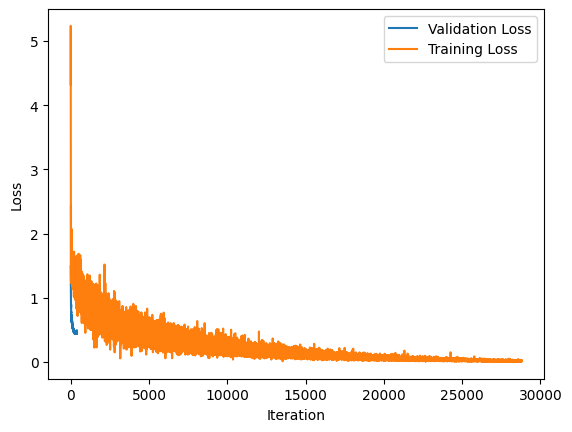

In [13]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Save the model weights
torch.save(model.state_dict(), 'Leukemia_weights.pth')

In [15]:
x, y = next(iter(test_loader))

In [16]:
model.eval()
y_pred = model(x.to(device)).argmax(1)

In [17]:
y # vere label

tensor([3, 1, 1, 0, 3, 3, 2, 2, 1, 2, 1, 3, 0, 2, 0, 3, 2, 2, 3, 1, 1, 0, 1, 3,
        3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 3, 3, 3, 2, 3, 1, 1, 0, 1, 0, 1,
        1, 3, 0, 0, 1, 1, 2, 3, 2, 3, 0, 2, 0, 3, 2, 0, 0, 3, 2, 2, 2, 3, 1, 2,
        1, 3, 3, 3, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 3,
        2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 1, 3, 3, 1, 3, 1, 3,
        2, 0, 2, 2, 1, 0, 3, 1, 2, 1, 3, 2, 0, 2, 2, 3, 1, 3, 0, 1, 2, 2, 2, 3,
        3, 1, 2, 3, 2, 1, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 0, 2, 1, 1, 2,
        2, 1, 2, 3, 2, 0, 3, 2, 2, 3, 0, 0, 0, 1, 2, 2, 1, 1, 3, 2, 0, 1, 1, 3,
        0, 2, 1, 3, 1, 0, 2, 0, 3, 2, 1, 1, 3, 3, 2, 0, 2, 1, 0, 3, 2, 3, 2, 3,
        3, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 3, 1, 2, 3, 1, 0, 3, 0, 1,
        1, 0, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 2, 0, 2,
        3, 3, 0, 3, 1, 2, 3, 1, 0, 1, 3, 1, 0, 2, 1, 3, 0, 1, 1, 1, 3, 0, 0, 2,
        2, 2, 2, 0, 2, 3, 3, 2, 3, 1, 0,

In [18]:
y_pred

tensor([3, 3, 2, 0, 3, 3, 2, 2, 1, 0, 1, 3, 1, 2, 2, 3, 2, 2, 3, 1, 1, 0, 1, 3,
        3, 3, 3, 2, 2, 2, 0, 2, 0, 0, 1, 0, 2, 3, 3, 3, 2, 3, 0, 1, 1, 0, 1, 3,
        1, 3, 0, 0, 1, 1, 2, 3, 2, 3, 0, 2, 0, 3, 2, 0, 0, 3, 2, 2, 2, 3, 1, 2,
        1, 3, 3, 3, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 3, 1, 3, 3, 2, 2, 1, 3, 3, 3,
        2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 3, 3, 1, 3, 1, 3,
        2, 0, 2, 2, 1, 0, 3, 1, 2, 1, 3, 1, 1, 0, 0, 3, 1, 3, 0, 1, 2, 2, 2, 3,
        3, 1, 2, 3, 2, 1, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 1, 2, 1, 1, 2,
        2, 1, 2, 3, 2, 0, 3, 0, 2, 3, 3, 0, 1, 2, 2, 0, 1, 1, 3, 2, 0, 1, 1, 3,
        0, 2, 1, 3, 1, 0, 2, 3, 3, 2, 1, 0, 3, 3, 2, 0, 2, 1, 0, 3, 2, 3, 0, 3,
        3, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 3, 1, 2, 3, 1, 2, 3, 0, 1,
        1, 0, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 2, 0, 2,
        3, 3, 0, 3, 1, 2, 3, 1, 0, 1, 3, 1, 0, 2, 1, 3, 3, 1, 1, 1, 3, 3, 0, 2,
        2, 2, 0, 0, 2, 3, 3, 2, 3, 1, 3,

In [19]:
# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.8875255623721882


In [27]:
model2 = LeukemiaClassifier()
model2 = model2.to(device)
model2.eval()

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model2(img.float().to(device))
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.24130879345603273
